#**Final Project Data 606: Capstone in Data Science:**

##**Cyber Bullying In Tweets**

Submitted by: Karan Ajay Pisay and Srashti Soni

**Importing Libraries:**

In [1]:
!pip install emoji -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
#importing libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import emoji
import string
import nltk
from PIL import Image
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
import pickle
import nltk
nltk.download('stopwords')
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/drive


**Getting the data:**

In [3]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/cyberbullying_tweets.csv")
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


**Data Overview**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


###Data Preprocessing

**Checking missing values**

In [5]:
df.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

In [6]:
# Value count based on bullying categories.
df['cyberbullying_type'].value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

In [7]:
# Renaming the columns of the dataset.
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})
df.head()

,text,sentiment
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [8]:
# Data Preprocessing

txt_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

from wordcloud import STOPWORDS
STOPWORDS.update(['rt', 'mkr', 'didn', 'bc', 'n', 'm', 'im', 'll', 'y', 've', 'u', 'ur', 'don', 't', 's','gt','p','ta','pvp','manag','kat','re','co','wa','https'])

def lower(text):
    return text.lower()

def remove_urls(text):
    return re.sub(txt_cleaning_re, ' ', text)

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

def remove_emoji(text):
    return emoji.replace_emoji(text,replace="")

# Fucntion to Convert text to lowercase, remove (/r, /n characters), URLs, non-utf characters, Numbers, punctuations,stopwords

def remove_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').lower()
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    text = re.sub(r'(.)1+', r'1', text)
    text = re.sub('[0-9]+', '', text)
    stopchars= string.punctuation
    table = str.maketrans('', '', stopchars)
    text = text.translate(table)
    # nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    return text

# Function to remove contractions
def remove_contraction(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

# Function to Clean Hashtags
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet))
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet))
    return new_tweet2

# Function to filter special characters
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

# Function to remove mutiple sequence spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

In [9]:
def cleaned_text(text):
    text = lower(text)
    text = remove_urls(text)
    text = remove_stopwords(text)
    text = remove_emoji(text)
    text = remove_all_entities(text)
    text = remove_contraction(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    return text

In [10]:
df['cleaned_text'] = df['text'].apply(cleaned_text)
df.head()

,text,sentiment,cleaned_text
0,"In other words #katandandre, your food was cra...",not_cyberbullying,words katandandre food crapilicious
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white theblock imacelebrityau today s...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcakes
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh thanks heads concerned another angry dude ...
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isis account pretending kurdish account islam ...


In [11]:
# Adding encoded column of sentiments
df["encoded_sentiment"] = df['sentiment'].replace({"religion": 1, "age": 2, "ethnicity": 3, "gender": 4, "other_cyberbullying": 5,"not_cyberbullying": 6})
df.head()

,text,sentiment,cleaned_text,encoded_sentiment
0,"In other words #katandandre, your food was cra...",not_cyberbullying,words katandandre food crapilicious,6
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white theblock imacelebrityau today s...,6
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcakes,6
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh thanks heads concerned another angry dude ...,6
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isis account pretending kurdish account islam ...,6


In [12]:
# Handling duplicates
df["cleaned_text"].duplicated().sum()

2874

In [13]:
# Removing duplicates
df.drop_duplicates("cleaned_text", inplace=True)

**Duplicates Removed**

### Tokenization

In [14]:
import nltk
nltk.download('punkt')
df['list_of_tweets'] = df['cleaned_text'].apply(word_tokenize)
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,text,sentiment,cleaned_text,encoded_sentiment,list_of_tweets
0,"In other words #katandandre, your food was cra...",not_cyberbullying,words katandandre food crapilicious,6,"[words, katandandre, food, crapilicious]"
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white theblock imacelebrityau today s...,6,"[aussietv, white, theblock, imacelebrityau, to..."
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcakes,6,"[classy, whore, red, velvet, cupcakes]"
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh thanks heads concerned another angry dude ...,6,"[meh, thanks, heads, concerned, another, angry..."
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isis account pretending kurdish account islam ...,6,"[isis, account, pretending, kurdish, account, ..."


In [15]:
text_length = []
for text in df.list_of_tweets:
    tweet_length = len(text)
    text_length.append(tweet_length)
df['text_len'] = text_length
df = df[df['text_len']!=0]
df.shape

(44817, 6)

##Applying Lemmatization for further analysis

In [16]:
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
lemmatizer=WordNetLemmatizer()
def lemmatizer_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

df['text']=df['text'].apply(lambda text: lemmatizer_words(text))

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [17]:
df.sentiment.unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

In [18]:
df.head()

,text,sentiment,cleaned_text,encoded_sentiment,list_of_tweets,text_len
0,"In other word #katandandre, your food wa crapi...",not_cyberbullying,words katandandre food crapilicious,6,"[words, katandandre, food, crapilicious]",4
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white theblock imacelebrityau today s...,6,"[aussietv, white, theblock, imacelebrityau, to...",10
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcakes,6,"[classy, whore, red, velvet, cupcakes]",5
3,"@Jason_Gio meh. :P thanks for the head up, but...",not_cyberbullying,meh thanks heads concerned another angry dude ...,6,"[meh, thanks, heads, concerned, another, angry...",8
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isis account pretending kurdish account islam ...,6,"[isis, account, pretending, kurdish, account, ...",7


# Exploratory Data Analysis:

In [19]:
#function for creating a word cloud
def word_cloud(cyberbullying_type):
    string = ""
    for i in df[df.sentiment == cyberbullying_type].text.values:
        string = string + " " + i.strip()

    custom_mask = np.array(Image.open('/content/drive/MyDrive/Twitter-logo-png.png'))
    mask_colors = ImageColorGenerator(custom_mask)
    wordcloud = WordCloud(background_color ='white',max_words=2000, max_font_size=256, width=custom_mask.shape[1],height=custom_mask.shape[0],
                mask = custom_mask,min_font_size = 10,color_func=mask_colors).generate(string)
 
    # plotting the WordCloud                    
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(cyberbullying_type)
    plt.show()
    del string

### Data Visualization:

In [20]:
import plotly.express as px

count1 = df['sentiment'].value_counts()
fig = px.pie(count1, names=count1.index, values=count1, 
             title='Cyberbullying Type Distribution', 
             hole=0.5, labels={'label': 'Sentiment', 'value': 'Count'},
             template='plotly_dark')

fig.show()

In [21]:
type_not_cyberbullying = df[df['sentiment']=='not_cyberbullying']
type_gender = df[df['sentiment']=='gender']
type_religion = df[df['sentiment']=='religion']
type_other_cyberbullying = df[df['sentiment']=='other_cyberbullying']
type_age = df[df['sentiment']=='age']
type_ethnicity = df[df['sentiment']=='ethnicity']

**Cyberbullying based on Gender:**

In [22]:
gender = Counter([item for sublist in type_gender['list_of_tweets'] for item in sublist])
top20_gender = pd.DataFrame(gender.most_common(20))
top20_gender.columns = ['Top Words','Count']
top20_gender.style.background_gradient(cmap='Blues')

,Top Words,Count
0,rape,4140
1,gay,3727
2,jokes,3415
3,joke,1799
4,people,998
5,call,988
6,sexist,979
7,women,910
8,bitch,855
9,female,832


In [23]:
import plotly.express as px


fig = px.bar(top20_gender, y='Count', x='Top Words', text_auto='.2s', title="Top 20 words in Cyberbullying based on Gender")
fig.update_traces(marker=dict(color='purple'))
fig.show()

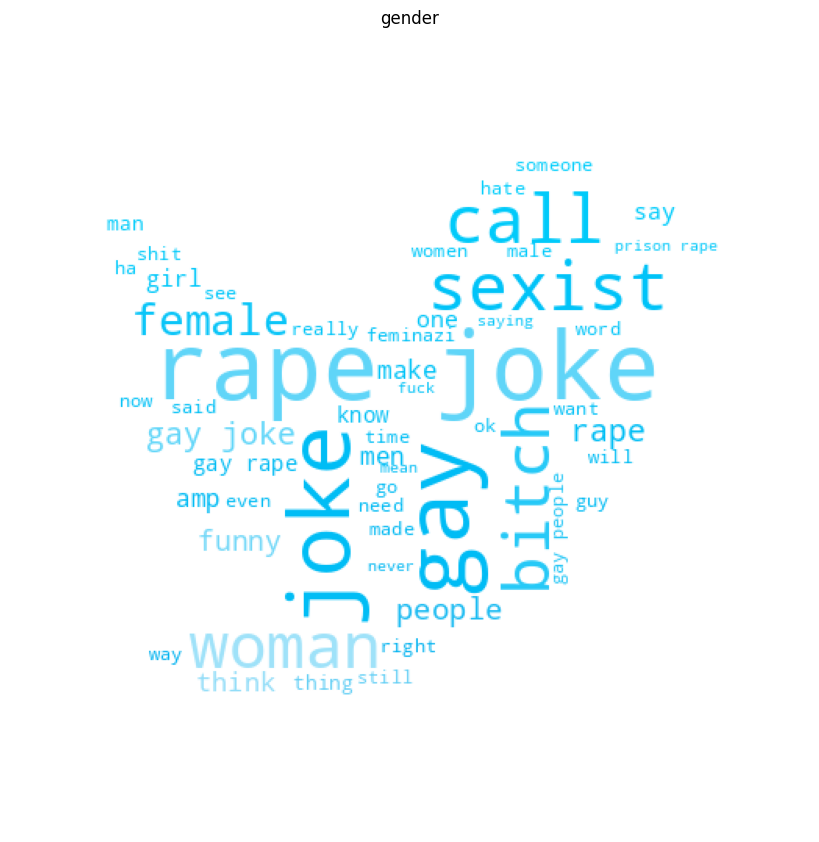

In [24]:
word_cloud('gender')

### Cyberbullying based on Religion:

In [25]:
religion = Counter([item for sublist in type_religion['list_of_tweets'] for item in sublist])
top20_religion = pd.DataFrame(religion.most_common(20))
top20_religion.columns = ['Top Words','Count']
top20_religion.style.background_gradient(cmap='Reds')

,Top Words,Count
0,muslims,2447
1,muslim,2401
2,idiot,1766
3,christian,1522
4,idiots,1346
5,islamic,1280
6,islam,1228
7,terrorism,1172
8,right,1088
9,radical,1080


In [26]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Pie(labels=top20_religion['Top Words'], values=top20_religion['Count'])])
fig.update_layout(title='Top 20 words in Cyberbullying based on Religion')
fig.show()

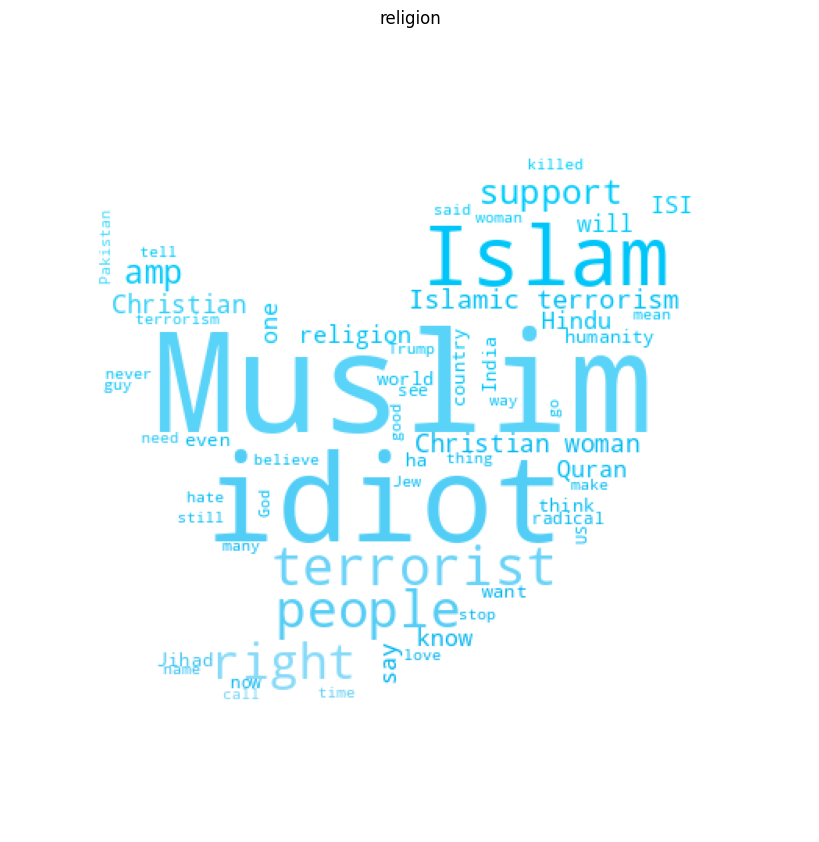

In [27]:
word_cloud('religion')

### Cyberbullying based on Age:

In [28]:
age = Counter([item for sublist in type_age['list_of_tweets'] for item in sublist])
top20_age = pd.DataFrame(age.most_common(20))
top20_age.columns = ['Top Words','Count']
top20_age.style.background_gradient(cmap='Purples')

,Top Words,Count
0,school,8190
1,high,4998
2,bullied,4349
3,bully,2727
4,girl,2334
5,girls,2316
6,bullies,1579
7,one,955
8,people,933
9,got,842


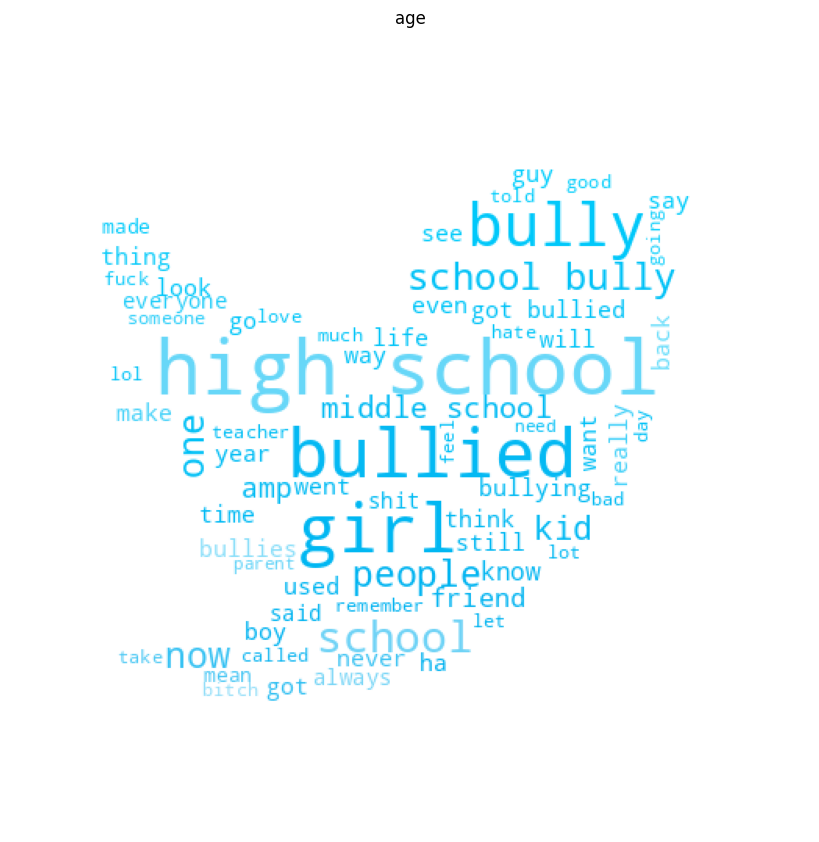

In [29]:
word_cloud('age')

### Cyberbullying based on Ethnicity:

In [30]:
ethnicity = Counter([item for sublist in type_ethnicity['list_of_tweets'] for item in sublist])
top20_ethnicity = pd.DataFrame(ethnicity.most_common(20))
top20_ethnicity.columns = ['Top Words','Count']
top20_ethnicity.style.background_gradient(cmap='Blues')

,Top Words,Count
0,fuck,5100
1,dumb,5079
2,nigger,4351
3,ass,2231
4,black,2094
5,white,1512
6,niggers,1312
7,people,1173
8,obama,1115
9,one,992


In [31]:
import plotly.express as px
from collections import Counter

ethnicity = Counter([item for sublist in type_ethnicity['list_of_tweets'] for item in sublist])
top20_ethnicity = pd.DataFrame(ethnicity.most_common(20))
top20_ethnicity.columns = ['Top Words', 'Count']

# Creating circular packing chart
fig = px.scatter(top20_ethnicity, x='Top Words', y='Count', size='Count', color='Count',
                 hover_name='Top Words', title='Circular Packing Chart of Top 20 Ethnicity Words',
                 template='plotly_dark', opacity=0.5)

# Set circular packing layout
fig.update_traces(marker=dict(line=dict(width=2, color='DarkSlateGrey')), textfont_size=14)
fig.update_layout(title_x=0.5, font_family='Rockwell', font_color='white',
                  xaxis=dict(showgrid=False, zeroline=False, showticklabels=True),
                  yaxis=dict(showgrid=False, zeroline=False, showticklabels=True),
                  width=800, height=600, margin=dict(l=50, r=50, b=100, t=100, pad=4))

# Show chart
fig.show()

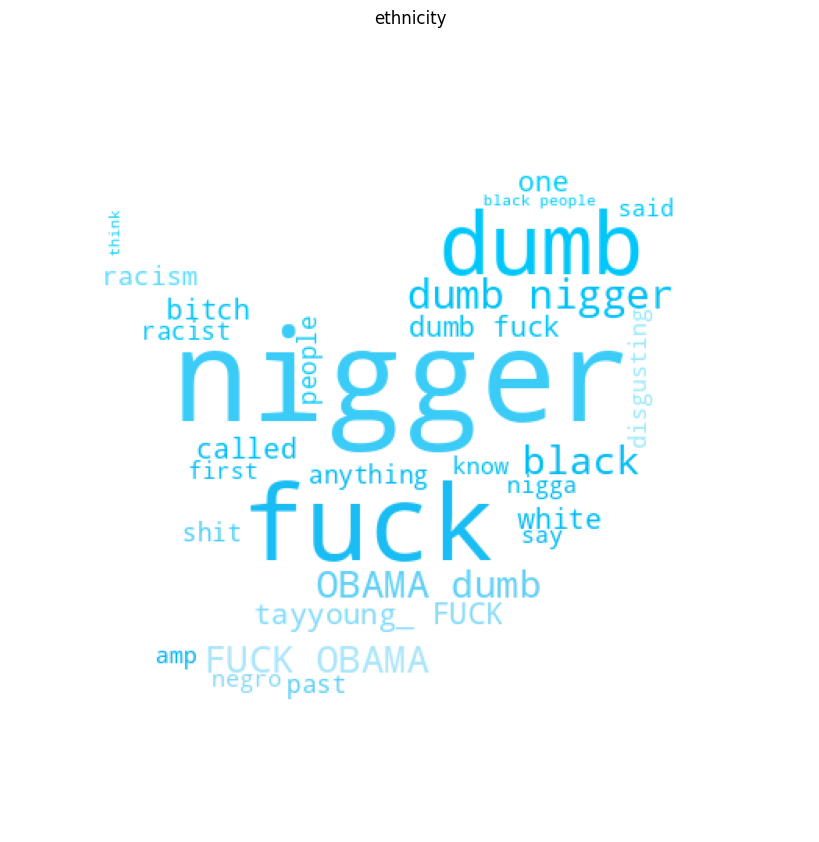

In [32]:
word_cloud('ethnicity')

### Cyberbullying based on other type

In [33]:
other_cyberbullying = Counter([item for sublist in type_other_cyberbullying['list_of_tweets'] for item in sublist])
top20_other_cyberbullying = pd.DataFrame(other_cyberbullying.most_common(20))
top20_other_cyberbullying.columns = ['Top_Words','Count']
top20_other_cyberbullying.style.background_gradient(cmap='Greens')

,Top_Words,Count
0,bully,509
1,fucking,360
2,people,354
3,know,215
4,one,202
5,bullying,198
6,bullied,196
7,think,194
8,hate,176
9,got,174


Text(0.5, 1.0, 'Top 20 words in Other type of Cyberbullying')

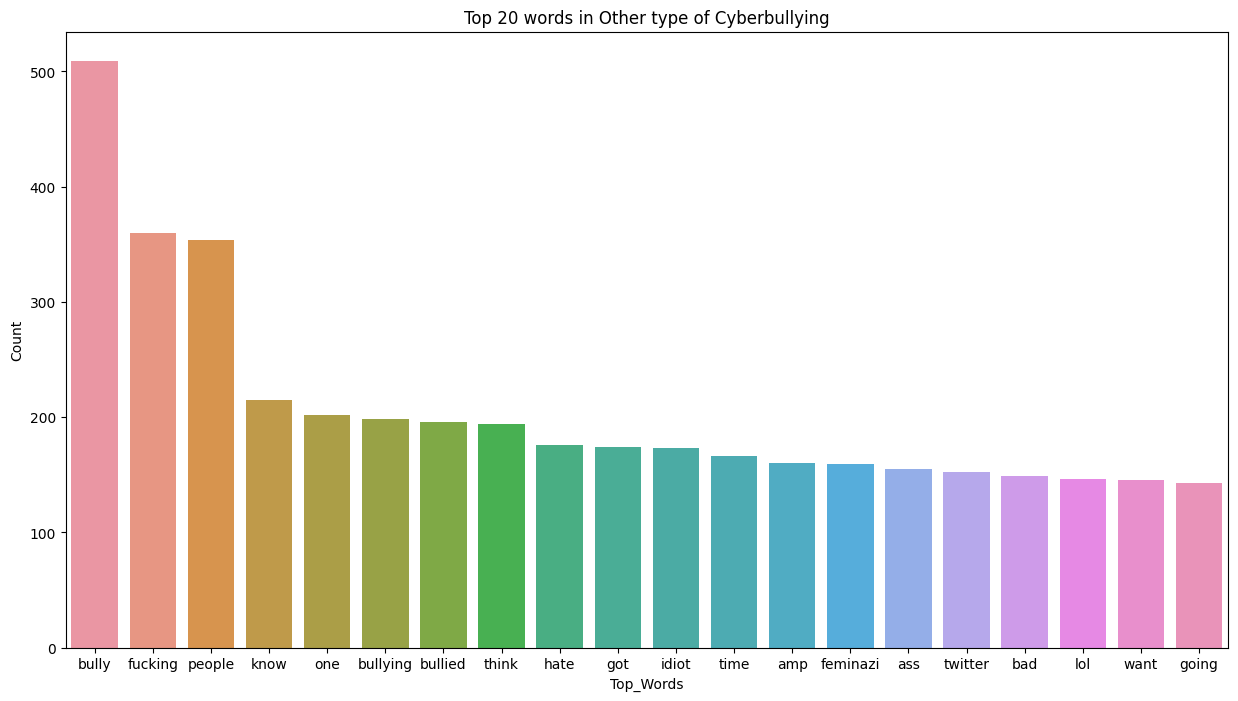

In [34]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=top20_other_cyberbullying, y="Count", x="Top_Words")
plt.title("Top 20 words in Other type of Cyberbullying")

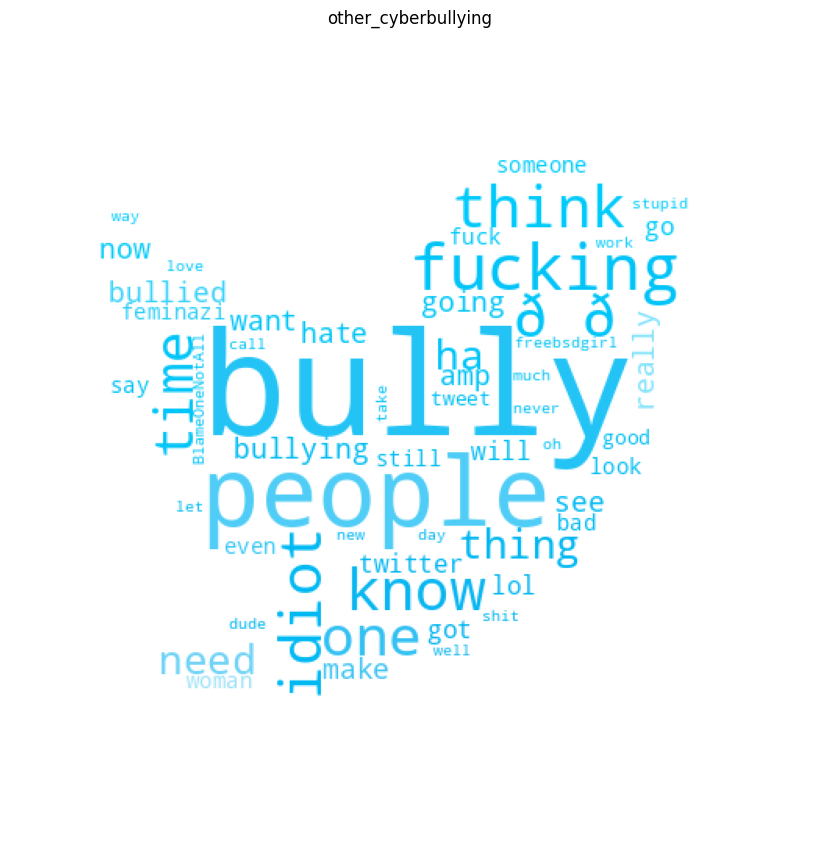

In [35]:
word_cloud('other_cyberbullying')

### Tweets based on not bullying:

In [36]:
not_cyberbullying = Counter([item for sublist in type_not_cyberbullying['list_of_tweets'] for item in sublist])
not_cyberbullying_top20 = pd.DataFrame(not_cyberbullying.most_common(20))
not_cyberbullying_top20.columns = ['Top_Words','Count']
not_cyberbullying_top20.style.background_gradient(cmap='GnBu')

,Top_Words,Count
0,bullying,672
1,bully,407
2,school,343
3,amp,281
4,people,272
5,one,247
6,go,226
7,know,218
8,time,207
9,andre,198


Text(0.5, 1.0, 'Top 20 words in Not Cyberbullying type')

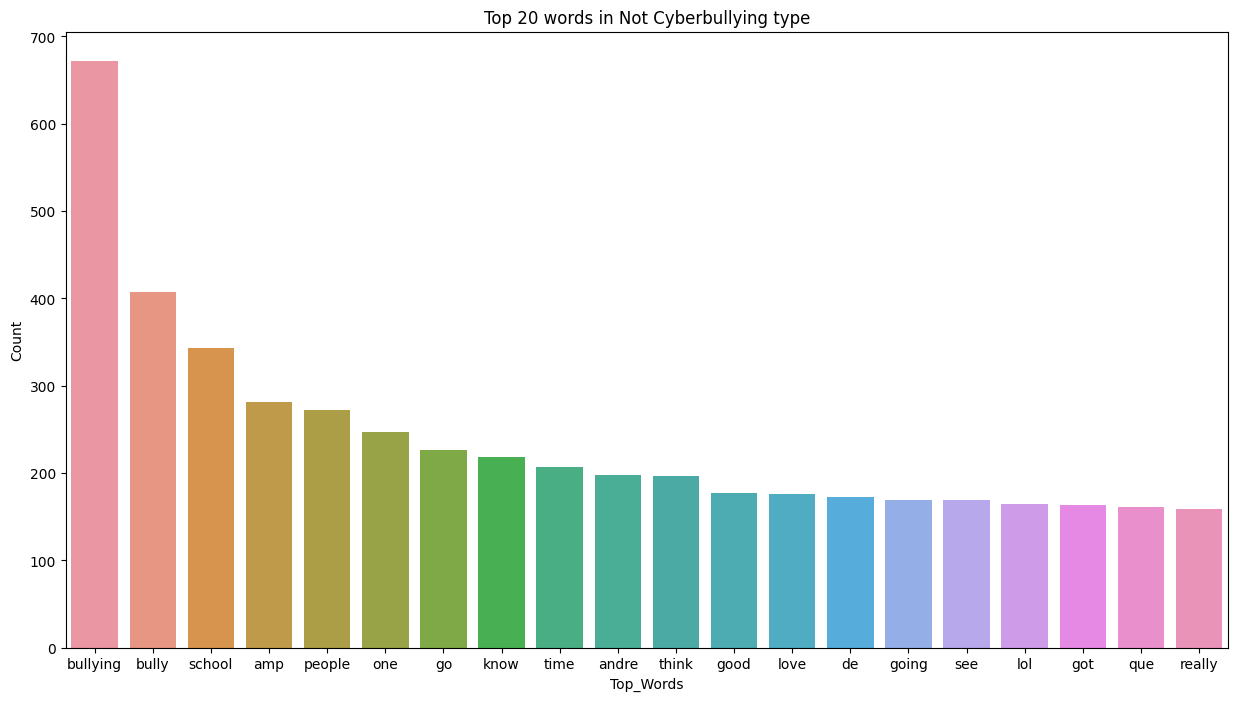

In [37]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=not_cyberbullying_top20, y="Count", x="Top_Words")
plt.title("Top 20 words in Not Cyberbullying type")

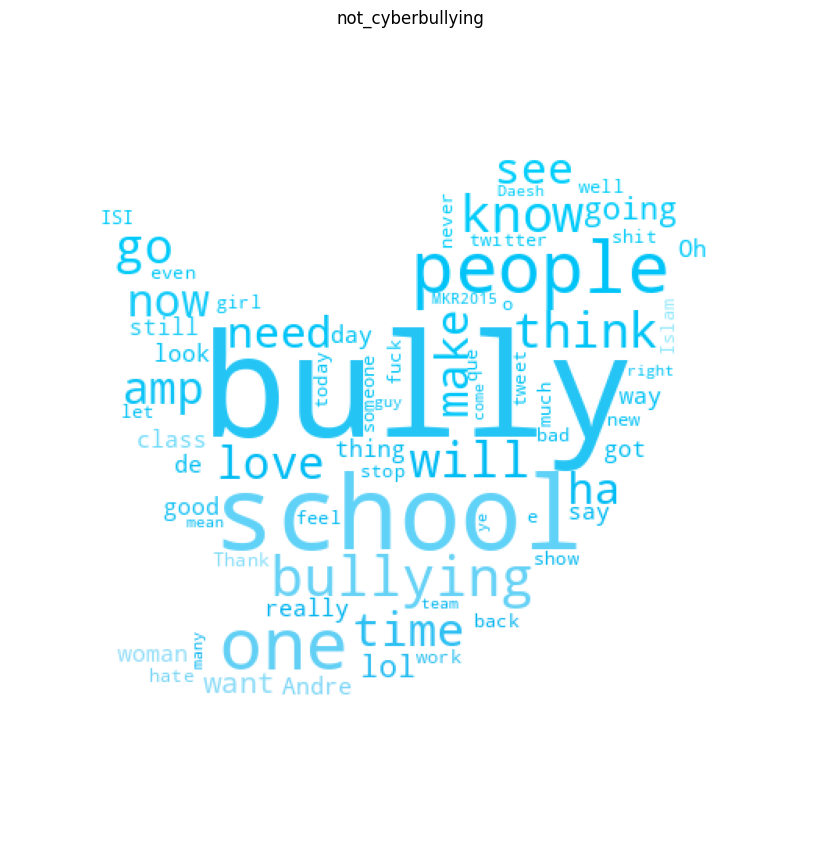

In [38]:
word_cloud('not_cyberbullying')

# EDA has been Completed!

In [39]:
df.head()

,text,sentiment,cleaned_text,encoded_sentiment,list_of_tweets,text_len
0,"In other word #katandandre, your food wa crapi...",not_cyberbullying,words katandandre food crapilicious,6,"[words, katandandre, food, crapilicious]",4
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white theblock imacelebrityau today s...,6,"[aussietv, white, theblock, imacelebrityau, to...",10
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcakes,6,"[classy, whore, red, velvet, cupcakes]",5
3,"@Jason_Gio meh. :P thanks for the head up, but...",not_cyberbullying,meh thanks heads concerned another angry dude ...,6,"[meh, thanks, heads, concerned, another, angry...",8
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isis account pretending kurdish account islam ...,6,"[isis, account, pretending, kurdish, account, ...",7


# Model Training:

In [40]:
sentiments = ["religion", "age", "ethnicity", "gender", "other_cyberbullying","not_cyberbullying"]

In [41]:
df1 = pd.DataFrame(df)

In [42]:
X = df['cleaned_text']
Y = df['encoded_sentiment']


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, stratify =Y, random_state = 42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(31371,) (31371,) (13446,) (13446,)


***TF-IDF Vectorization***

In [44]:
tf_idf = TfidfVectorizer()
X_train_tf = tf_idf.fit_transform(X_train)
X_test_tf = tf_idf.transform(X_test)
print(X_train_tf.shape)
print(X_test_tf.shape)

(31371, 39597)
(13446, 39597)


In [45]:
X_train_tf

<31371x39597 sparse matrix of type '<class 'numpy.float64'>'
	with 382503 stored elements in Compressed Sparse Row format>

In [46]:
def filter_type(s, num=True):
    s_new = pd.to_numeric(s, errors='coerce')
    if num:
        return s[s_new.notnull()]
    else:
        return s[s_new.isnull()]

In [47]:
X_train = filter_type(X_train, num=False)
X_test = filter_type(X_train, num=False)


X_train = X_train.to_frame()
X_test = X_test.to_frame()

## Trying Different Models:

In [48]:
#Logistic Regression Model
log_reg = LogisticRegression()

In [49]:
log_cv_score = cross_val_score(log_reg,X_train_tf,y_train,cv=5,scoring='f1_macro',n_jobs=-1)

In [50]:
mean_log_cv = np.mean(log_cv_score) * 100
print("f1 score of logistic regression model is:", round(mean_log_cv, 2))

f1 score of logistic regression model is: 82.47


In [51]:
# Support Vector Machine
lin_svc = LinearSVC()

In [52]:
lin_svc_cv_score = cross_val_score(lin_svc,X_train_tf,y_train,cv=5,scoring='f1_macro',n_jobs=-1)
mean_lin_svc_cv = np.mean(lin_svc_cv_score) * 100
print("f1 score of SVM is:", round(mean_lin_svc_cv, 2))

f1 score of SVM is: 82.88


In [53]:
# Naive Bayes Classifier
multiNB = MultinomialNB()

In [54]:
multiNB_cv_score = cross_val_score(multiNB,X_train_tf,y_train,cv=5,scoring='f1_macro',n_jobs=-1)
mean_multiNB_cv = np.mean(multiNB_cv_score) * 100
print("f1 score of Naive Bayes Classifier is:", round(mean_multiNB_cv, 2))

f1 score of Naive Bayes Classifier is: 67.41


In [55]:
# Decision Tree Classifier
decision_tree = DecisionTreeClassifier()

In [56]:
decision_tree_cv_score = cross_val_score(decision_tree,X_train_tf,y_train,cv=5,scoring='f1_macro',n_jobs=-1)
mean_decision_tree_cv = np.mean(decision_tree_cv_score) * 100
print("f1 score of decision tree classifier is:", round(mean_decision_tree_cv, 2))

f1 score of decision tree classifier is: 81.06


In [57]:
# Random Forest Classifier
random_forest = RandomForestClassifier()

In [58]:
random_forest_cv_score = cross_val_score(random_forest,X_train_tf,y_train,cv=5,scoring='f1_macro',n_jobs=-1)
mean_random_forest_cv = np.mean(random_forest_cv_score) * 100
print("f1 score of Random Forest Classifier is:",round(mean_random_forest_cv,2))

f1 score of Random Forest Classifier is: 82.57


In [59]:
# AdaBoost Classifier
ada_boost = AdaBoostClassifier()

In [60]:
ada_boost_cv_score = cross_val_score(ada_boost,X_train_tf,y_train,cv=5,scoring='f1_macro',n_jobs=-1)
mean_ada_boost_cv = np.mean(ada_boost_cv_score) * 100
print("f1 score of AdaBoost Classifier is:", round(mean_ada_boost_cv, 2))

f1 score of AdaBoost Classifier is: 75.13


# Fine Tuning SVM using grid search technique

In [62]:
svc_1 = LinearSVC()
param_grid = {'C':[0.0001,0.001,0.01,0.1,1,10],
             'loss':['hinge','squared_hinge'],
             'fit_intercept':[True,False]}
grid_search = GridSearchCV(svc_1,param_grid,cv=5,scoring='f1_macro',n_jobs=-1,verbose=0,return_train_score=True)
grid_search.fit(X_train_tf,y_train)

GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'fit_intercept': [True, False],
                         'loss': ['hinge', 'squared_hinge']},
             return_train_score=True, scoring='f1_macro')

In [63]:
grid_search.best_estimator_

LinearSVC(C=1, loss='hinge')

In [64]:
grid_search.best_score_

0.8305390273870916

### Model Evaluation

In [65]:
lin_svc.fit(X_train_tf,y_train)
y_pred = lin_svc.predict(X_test_tf)

In [66]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

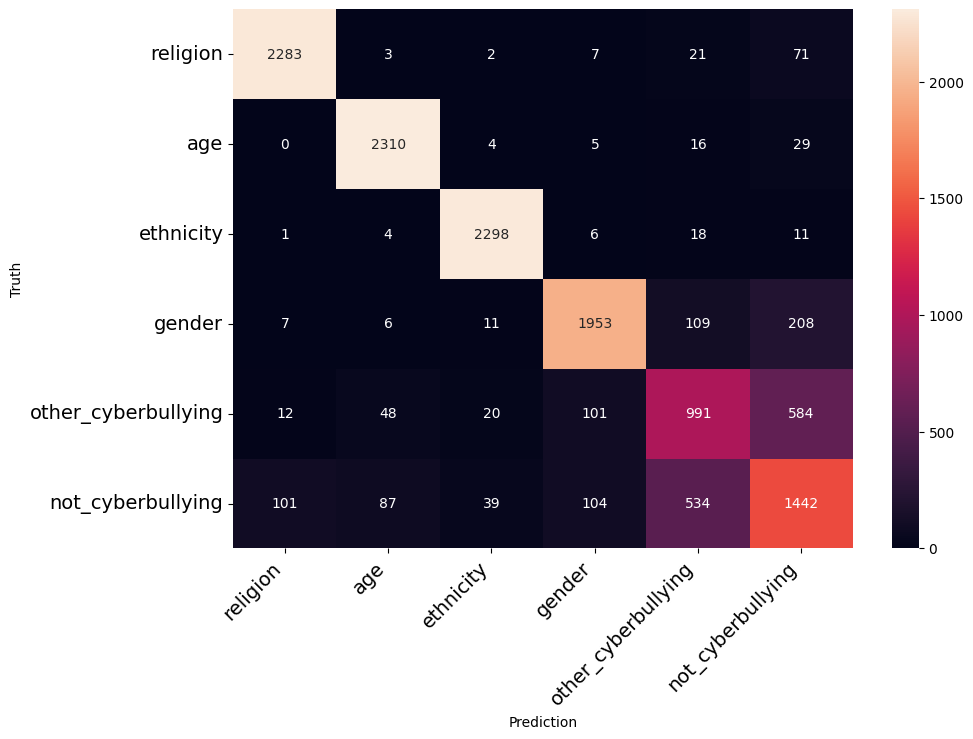

In [67]:
cm = confusion_matrix(y_test,y_pred)
print_confusion_matrix(cm,sentiments)

In [68]:
print('Classification Report:\n',classification_report(y_test, y_pred, target_names=sentiments))

Classification Report:
                      precision    recall  f1-score   support

           religion       0.95      0.96      0.95      2387
                age       0.94      0.98      0.96      2364
          ethnicity       0.97      0.98      0.98      2338
             gender       0.90      0.85      0.87      2294
other_cyberbullying       0.59      0.56      0.58      1756
  not_cyberbullying       0.61      0.63      0.62      2307

           accuracy                           0.84     13446
          macro avg       0.83      0.83      0.83     13446
       weighted avg       0.84      0.84      0.84     13446



## Saving the Model:

In [69]:
# pickle.dump(tf_idf, open('vectorizer.pkl', 'wb'))
# pickle.dump(lin_svc, open('model.pkl', 'wb'))